## Importing libraries and authenticated access




In [1]:
!pip install lightgbm

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta
from tqdm import tqdm
import calendar as ca

import time
import gc
import pickle

import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Loading the full dataset (5+ GB)

In [3]:
# https://www.kaggle.com/heyt0ny/read-data-for-low-memory-usage
class Data(object):
    def __init__(self, data_folder, test_the_script = False):
        self.DATA_FOLDER = data_folder
        self.test_the_script = test_the_script
        self.read_data()
        print('Train shape: ', self.train.shape)

    def read_data(self):

        self.nrows = None
        if self.test_the_script:
            self.nrows = 1000

        self.train = self.read_train_test_low_memory(train_flag = True)
        self.test = self.read_train_test_low_memory(train_flag = False)
        self.stores = self.read_stores_low_memory()
        self.items = self.read_items_low_memory()
        self.weather_oil_holiday = self.read_oil_weather_holiday_low_memory()
        self.transactions = self.read_transactions_low_memory()
        self.weather = self.read_weather_low_memory()
            
    def read_train_test_low_memory(self, train_flag = True):
        filename = 'train'
        if not train_flag: filename = 'test'

        types = {'id': 'int64',
                'item_nbr': 'int32',
                'store_nbr': 'int8',
                'unit_sales': 'float32'
            }
        # Skipping rows till 2016
        data = pd.read_csv(self.DATA_FOLDER + filename + '.csv', parse_dates = ['date'], dtype = types, 
                           converters={'unit_sales': lambda u: np.log1p(float(u)) if float(u) > 0 else 0},
                        nrows = self.nrows, infer_datetime_format = True, low_memory = True, skiprows=range(1, 66458909))
        
        # data['lg_unit_sales'] = data['unit_sales'].apply(lambda u: np.log1p(float(u)) if float(u) > 0 else 0)
        
        # Missing value imputation for onpromotion column
        data['onpromotion'].fillna(False, inplace = True)
        data['onpromotion'] = data['onpromotion'].map({False : 0, True : 1})
        data['onpromotion'] = data['onpromotion'].astype('int8')
        
        return data

    def read_stores_low_memory(self):
        types = {'cluster': 'int32',
                'store_nbr': 'int8',
                }
        data = pd.read_csv(self.DATA_FOLDER + 'stores.csv', dtype = types, low_memory = True)
        return data

    def read_items_low_memory(self):
        types = {'item_nbr': 'int32',
                'perishable': 'int8',
                'class' : 'int16'
                }
        data = pd.read_csv(self.DATA_FOLDER + 'items.csv', dtype = types, low_memory = True)
        return data

    def read_oil_weather_holiday_low_memory(self):
        types = {'dcoilwtico_imputed': 'float32',
                 'AvgTemp': 'int8',
                 'store_nbr' : 'int8',
                 'is_holiday' : 'int8'
                }
        data = pd.read_csv(self.DATA_FOLDER + 'holiday_weather_oil_combined.csv', parse_dates = ['date'], dtype = types, 
                                infer_datetime_format = True, low_memory = True)
        return data

    def read_weather_low_memory(self):
        types = {'AvgTemp': 'int8',
                 'MaxTemp': 'int8'
                }
        data = pd.read_csv(self.DATA_FOLDER + 'weather.csv', parse_dates = ['Date'], dtype = types, 
                                infer_datetime_format = True, low_memory = True)
        data.rename(columns={'Date':'date', 'location':'city'}, inplace=True)
        return data
    
    def read_transactions_low_memory(self):
        types = {'transactions': 'int16',
                'store_nbr' : 'int8'
                }
        data = pd.read_csv(self.DATA_FOLDER + 'transactions.csv', parse_dates = ['date'], dtype = types, 
                                infer_datetime_format = True, low_memory = True)
        return data

In [4]:
start_time = time.time()
data = Data(data_folder = 'drive/My Drive/Colab Notebooks/Wishmart/data/', test_the_script = False)
end_time = time.time()
print("Total time elapsed: {} mins.".format((end_time - start_time)/60))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: ParserWarning: Both a converter and dtype were specified for column unit_sales - only the converter will be used


Train shape:  (59038132, 6)
Total time elapsed: 3.4142388184865315 mins.


In [5]:
data.stores['city'] = data.stores.city.str.lower()
df_weather_store = pd.merge(data.stores[['store_nbr', 'city']], data.weather[['date', 'AvgTemp', 'city']], on='city')

# LGBM Starter

In [6]:
SELECTED_STORES = [i for i in range(1, 20)]
df_train = data.train.loc[(data.train.store_nbr.isin(SELECTED_STORES)) & (data.train.date >= datetime(2017, 1, 1))]
df_items = data.items.set_index('item_nbr')

In [7]:
df_train_ext = pd.merge(df_train, data.items[['item_nbr', 'perishable', 'family', 'class']], on='item_nbr')  # Train and items (perishable state)
df_train_ext = pd.merge(df_train_ext,
                    data.weather_oil_holiday[['date', 'store_nbr', 'is_holiday', 'AvgTemp', 'dcoilwtico_imputed']],
                    on=['date', 'store_nbr'], how='left')  # Merge weather, oil and holiday

del df_train_ext['id']
df_train_ext.rename(columns={'dcoilwtico_imputed': 'oil_price', 'AvgTemp': 'avg_temp', 'class': 'item_class'}, inplace=True)
df_train_ext.set_index(["store_nbr", "item_nbr", "date"], inplace=True)

In [8]:
df_2017 = df_train.set_index(["store_nbr", "item_nbr", "date"])[["unit_sales"]].unstack(level=-1).fillna(0)
df_2017.columns = df_2017.columns.get_level_values(1)

In [9]:
promo_2017 = df_train.set_index(["store_nbr", "item_nbr", "date"])[["onpromotion"]].unstack(level=-1).fillna(0)
promo_2017.columns = promo_2017.columns.get_level_values(1)

In [10]:
holiday_2017 = df_train_ext[["is_holiday"]].unstack(level=-1).fillna(0)
holiday_2017.columns = holiday_2017.columns.get_level_values(1)

In [11]:
df_temp_2017 = df_train_ext[["avg_temp"]].unstack(level=-1).fillna(0)
df_temp_2017.columns = df_temp_2017.columns.get_level_values(1)

In [12]:
for col_date in tqdm(df_temp_2017.columns.get_level_values(0)):
  for row_store in df_temp_2017.index.levels[0]:
    avg_temp = df_weather_store.loc[(df_weather_store.store_nbr == row_store) & (df_weather_store.date == col_date)]['AvgTemp'].iloc[0]
    df_temp_2017.loc[df_temp_2017.index.get_level_values('store_nbr') == row_store, col_date] = avg_temp

100%|██████████| 226/226 [00:14<00:00, 15.24it/s]


In [13]:
df_items_2017 = df_items.reindex(df_2017.index.get_level_values(1))

In [14]:
def get_timespan(df, dt, minus, periods, freq='D'):
    return df[pd.date_range(dt - timedelta(days=minus), periods=periods, freq=freq)]

In [15]:
# get_timespan(df_2017, date(2017, 5, 24)+timedelta(days=7 * 1), 1, 1).values.ravel().shape

In [16]:
def prepare_dataset(t2017, is_train=True):
    X = pd.DataFrame({
        "perishable": df_items_2017.perishable.values.ravel(),
        "day_1_2017": get_timespan(df_2017, t2017, 1, 1).values.ravel(),
        "mean_3_2017": get_timespan(df_2017, t2017, 3, 3).mean(axis=1).values,
        "mean_7_2017": get_timespan(df_2017, t2017, 7, 7).mean(axis=1).values,
        "mean_14_2017": get_timespan(df_2017, t2017, 14, 14).mean(axis=1).values,
        "mean_30_2017": get_timespan(df_2017, t2017, 30, 30).mean(axis=1).values,
        "mean_60_2017": get_timespan(df_2017, t2017, 60, 60).mean(axis=1).values,
        "mean_140_2017": get_timespan(df_2017, t2017, 140, 140).mean(axis=1).values,
        "promo_14_2017": get_timespan(promo_2017, t2017, 14, 14).sum(axis=1).values,
        "promo_60_2017": get_timespan(promo_2017, t2017, 60, 60).sum(axis=1).values,
        "promo_140_2017": get_timespan(promo_2017, t2017, 140, 140).sum(axis=1).values,
        "holiday_14_2017": get_timespan(holiday_2017, t2017, 14, 14).sum(axis=1).values,
        "holiday_60_2017": get_timespan(holiday_2017, t2017, 60, 60).sum(axis=1).values,
        "holiday_140_2017": get_timespan(holiday_2017, t2017, 140, 140).sum(axis=1).values,
        "day_1_temp": get_timespan(df_temp_2017, t2017, 1, 1).values.ravel(),
        "mean_2_temp": get_timespan(df_temp_2017, t2017, 2, 2).mean(axis=1).values,
        "mean_3_temp": get_timespan(df_temp_2017, t2017, 3, 3).mean(axis=1).values,
        "mean_5_temp": get_timespan(df_temp_2017, t2017, 5, 5).mean(axis=1).values,
        "mean_7_temp": get_timespan(df_temp_2017, t2017, 7, 7).mean(axis=1).values
    })
    for i in range(7):
        X['mean_4_dow{}_2017'.format(i)] = get_timespan(df_2017, t2017, 28-i, 4, freq='7D').mean(axis=1).values
        X['mean_20_dow{}_2017'.format(i)] = get_timespan(df_2017, t2017, 140-i, 20, freq='7D').mean(axis=1).values
    for i in range(16):
        X["promo_{}".format(i)] = promo_2017[t2017 + timedelta(days=i)].values.astype(np.uint8)
        # X["holiday_{}".format(i)] = holiday_2017[t2017 + timedelta(days=i)].values.astype(np.uint8)
    if is_train:
        y = df_2017[
            pd.date_range(t2017, periods=16)
        ].values
        return X, y
    return X

In [17]:
print("Preparing dataset...")

t2017 = date(2017, 5, 24)
X_l, y_l = [], []
for i in range(6):
    delta = timedelta(days=7 * i)
    X_tmp, y_tmp = prepare_dataset(t2017 + delta)
    X_l.append(X_tmp)
    y_l.append(y_tmp)

X_train = pd.concat(X_l, axis=0)
y_train = np.concatenate(y_l, axis=0)
del X_l, y_l
X_val, y_val = prepare_dataset(date(2017, 7, 12))
X_test, y_test = prepare_dataset(date(2017, 7, 31))

Preparing dataset...


In [18]:
params = {
    'num_leaves': 60,
    'objective': 'regression_l2',
    'max_depth': 10,
    'min_data_per_leaf': 300,
    'learning_rate': 0.05,
    'boosting_type': 'gbdt',
    'colsample_bytree': 0.4,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 1,
    'metric': 'l2',
    'num_threads': 4
}

In [19]:
MAX_ROUNDS = 1000
val_pred = []
test_pred = []
cate_vars = []
feature_importance_data = []

for i in range(16):

    print("=" * 50)
    print("Step %d" % (i+1))
    print("=" * 50)

    dtrain = lgb.Dataset(
        X_train, label=y_train[:, i],
        categorical_feature=cate_vars,
        weight=pd.concat([df_items_2017["perishable"]] * 6) * 0.25 + 1
    )
    dval = lgb.Dataset(
        X_val, label=y_val[:, i], reference=dtrain,
        weight=df_items_2017["perishable"].values * 0.25 + 1,
        categorical_feature=cate_vars)
    bst = lgb.train(
        params, dtrain, num_boost_round=MAX_ROUNDS,
        valid_sets=[dtrain, dval], early_stopping_rounds=50, verbose_eval=50
    )
    # print("\n".join(("%s: %.2f" % x) for x in sorted(
    #     zip(X_train.columns, bst.feature_importance("gain")),
    #     key=lambda x: x[1], reverse=True
    # )))

    f_importance = ["Step {}".format(i)] + [fx for fx in bst.feature_importance("gain")]
    feature_importance_data.append(f_importance)

    val_pred.append(bst.predict(
        X_val, num_iteration=bst.best_iteration or MAX_ROUNDS))
    test_pred.append(bst.predict(
        X_test, num_iteration=bst.best_iteration or MAX_ROUNDS))

    # Save model
    with open('lgb_step_{}.pickle'.format(i), 'wb') as file:
        pickle.dump(bst, file)



Step 1


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds.
[50]	training's l2: 0.309122	valid_1's l2: 0.297481
[100]	training's l2: 0.295252	valid_1's l2: 0.289638
[150]	training's l2: 0.291089	valid_1's l2: 0.289133
[200]	training's l2: 0.28852	valid_1's l2: 0.288776
[250]	training's l2: 0.286409	valid_1's l2: 0.288736
Early stopping, best iteration is:
[226]	training's l2: 0.287394	valid_1's l2: 0.288689
Step 2
Training until validation scores don't improve for 50 rounds.
[50]	training's l2: 0.331023	valid_1's l2: 0.327627
[100]	training's l2: 0.317826	valid_1's l2: 0.324088
Early stopping, best iteration is:
[72]	training's l2: 0.322323	valid_1's l2: 0.323368
Step 3
Training until validation scores don't improve for 50 rounds.
[50]	training's l2: 0.338883	valid_1's l2: 0.331371
[100]	training's l2: 0.322669	valid_1's l2: 0.322674
[150]	training's l2: 0.317144	valid_1's l2: 0.322336
Early stopping, best iteration is:
[129]	training's l2: 0.31891	valid_1's l2: 0.321835
Step 4
Train

In [20]:
# Save feature importance in a dataframe
pd.DataFrame(feature_importance_data, columns=['Step'] + list(X_train.columns)).to_csv('feature_importance.csv', index=None)

print("Validation LOG mse:", mean_squared_error(y_val, np.array(val_pred).transpose(), sample_weight=(df_items_2017["perishable"].values * 0.25 + 1)))
print("Test LOG mse:", mean_squared_error(y_test, np.array(test_pred).transpose(), sample_weight=(df_items_2017["perishable"].values * 0.25 + 1)))

print("Validation mse:", mean_squared_error(np.clip(np.expm1(y_val), 0, 1000), np.clip(np.expm1(np.array(val_pred).transpose()), 0, 1000), sample_weight=(df_items_2017["perishable"].values * 0.25 + 1)))
print("Test mse:", mean_squared_error(np.clip(np.expm1(y_test), 0, 1000), np.clip(np.expm1(np.array(test_pred).transpose()), 0, 1000), sample_weight=(df_items_2017["perishable"].values * 0.25 + 1)))

Validation LOG mse: 0.3413290415386183
Test LOG mse: 0.3581813959009428
Validation mse: 60.98214386291387
Test mse: 70.6768195138082


In [21]:
print("Validation mse:", mean_squared_error(np.clip(np.expm1(y_val), 0, 1000), np.clip(np.expm1(np.array(val_pred).transpose()), 0, 1000), sample_weight=(df_items_2017["perishable"].values * 0.25 + 1)))
print("Test mse:", mean_squared_error(np.clip(np.expm1(y_test), 0, 1000), np.clip(np.expm1(np.array(test_pred).transpose()), 0, 1000), sample_weight=(df_items_2017["perishable"].values * 0.25 + 1)))

Validation mse: 60.98214386291387
Test mse: 70.6768195138082


In [22]:
print("Combine with the test data split...")

df_preds_lg = pd.DataFrame(
    np.array(test_pred).transpose(), index=df_2017.index,
    columns=pd.date_range("2017-07-31", periods=16)
).stack().to_frame("log_predicted_unit_sales")
df_preds_lg.index.set_names(["store_nbr", "item_nbr", "date"], inplace=True)

df_test_lg = pd.DataFrame(
    y_test, index=df_2017.index,
    columns=pd.date_range("2017-07-31", periods=16)
).stack().to_frame("log_actual_unit_sales")
df_test_lg.index.set_names(["store_nbr", "item_nbr", "date"], inplace=True)


comb_df = pd.concat([df_preds_lg, df_test_lg], axis=1)
comb_df['predicted_unit_sales'] = np.clip(np.expm1(comb_df["log_predicted_unit_sales"]), 0, 1000)
comb_df['actual_unit_sales'] = np.clip(np.expm1(comb_df["log_actual_unit_sales"]), 0, 1000)
# comb_df['perishable'] = df_items_2017["perishable"]

Combine with the test data split...


In [23]:
print(date(2017, 7, 31))

2017-07-31


In [24]:
comb_df.reset_index()

,store_nbr,item_nbr,date,log_predicted_unit_sales,log_actual_unit_sales,predicted_unit_sales,actual_unit_sales
0,1,96995,2017-07-31,0.076272,1.098612,0.079256,2.0
1,1,96995,2017-08-01,0.106405,0.000000,0.112272,0.0
2,1,96995,2017-08-02,0.089512,0.693147,0.093641,1.0
3,1,96995,2017-08-03,0.193762,1.098612,0.213808,2.0
4,1,96995,2017-08-04,0.169036,0.000000,0.184163,0.0
...,...,...,...,...,...,...,...
911995,19,2116416,2017-08-11,1.208812,2.639057,2.349504,13.0
911996,19,2116416,2017-08-12,1.221084,0.693147,2.390862,1.0
911997,19,2116416,2017-08-13,0.968107,0.000000,1.632955,0.0
911998,19,2116416,2017-08-14,0.837099,0.000000,1.309656,0.0


In [25]:
groued_df = comb_df[['actual_unit_sales', 'predicted_unit_sales']].reset_index().groupby(['date', 'store_nbr']).sum().reset_index()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To co

<Figure size 1440x360 with 0 Axes>

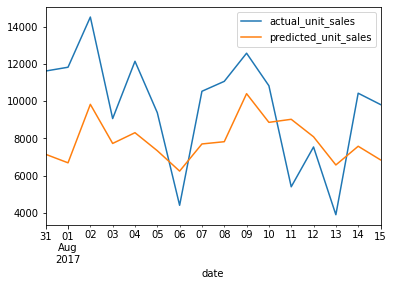

<Figure size 1440x360 with 0 Axes>

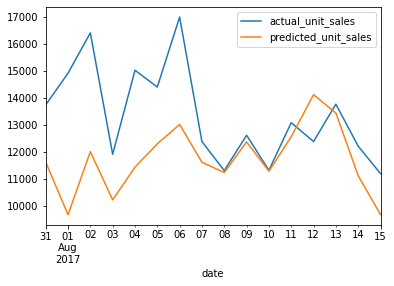

<Figure size 1440x360 with 0 Axes>

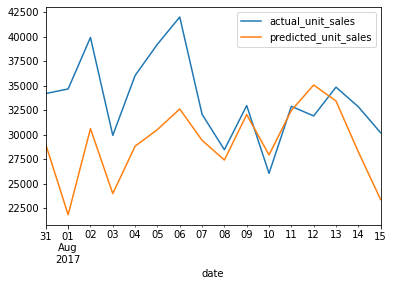

<Figure size 1440x360 with 0 Axes>

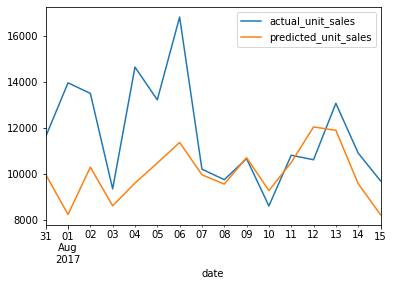

<Figure size 1440x360 with 0 Axes>

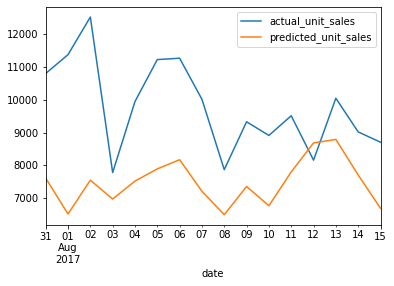

<Figure size 1440x360 with 0 Axes>

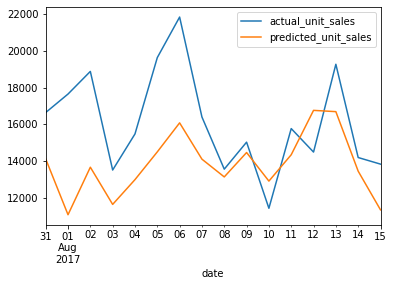

<Figure size 1440x360 with 0 Axes>

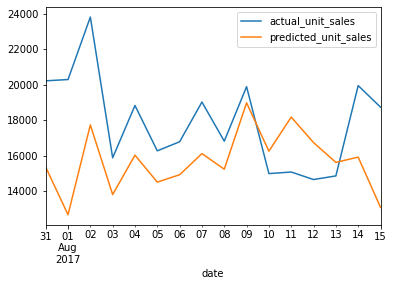

<Figure size 1440x360 with 0 Axes>

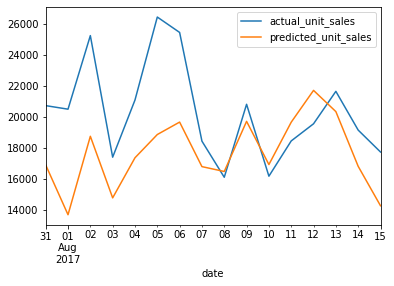

<Figure size 1440x360 with 0 Axes>

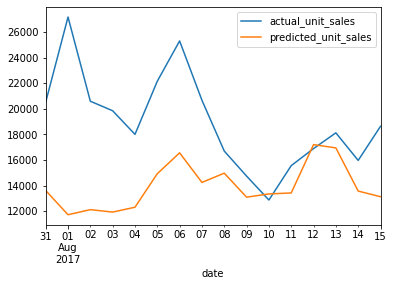

<Figure size 1440x360 with 0 Axes>

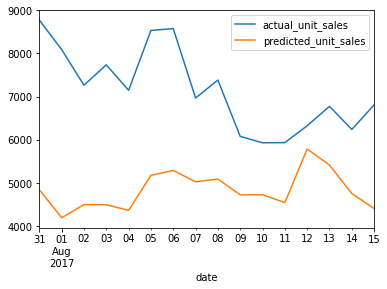

<Figure size 1440x360 with 0 Axes>

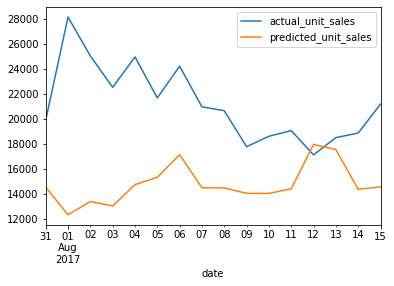

<Figure size 1440x360 with 0 Axes>

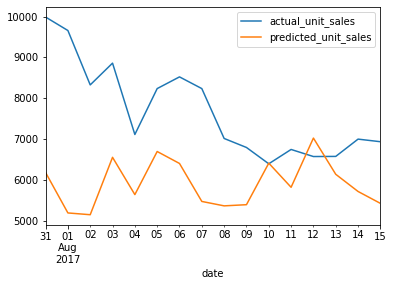

<Figure size 1440x360 with 0 Axes>

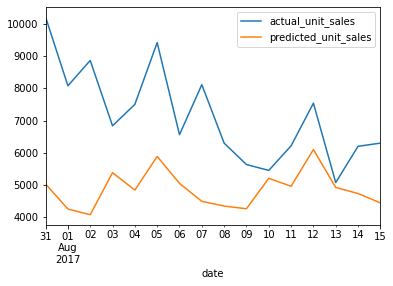

<Figure size 1440x360 with 0 Axes>

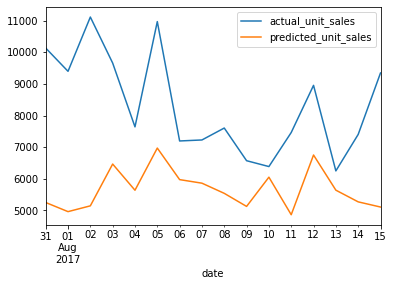

<Figure size 1440x360 with 0 Axes>

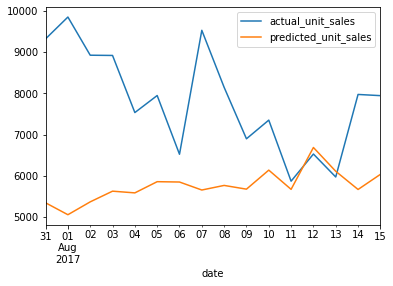

<Figure size 1440x360 with 0 Axes>

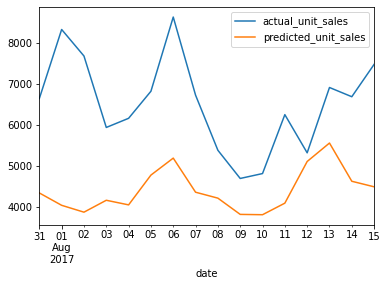

<Figure size 1440x360 with 0 Axes>

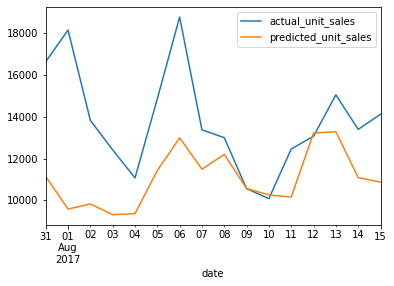

<Figure size 1440x360 with 0 Axes>

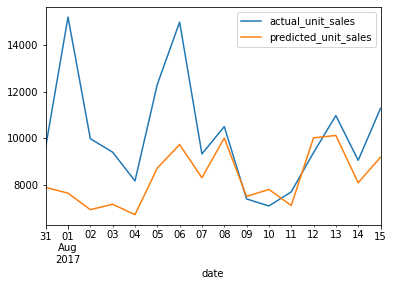

<Figure size 1440x360 with 0 Axes>

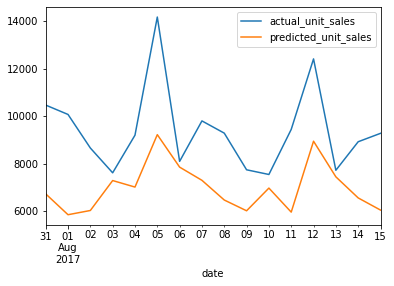

In [26]:
for i in range(1, 20):
  plt.figure(figsize=(20, 5))
  groued_df[groued_df.store_nbr == i].plot(x="date", y=["actual_unit_sales","predicted_unit_sales" ])

In [27]:
out_filename = 'drive/My Drive/Colab Notebooks/Wishmart/model_outputs/' + 'lgbm_log_scaled_out.csv'
merge_df = pd.merge(comb_df.reset_index(), df_items_2017.reset_index(), on='item_nbr')
merge_df.to_csv(out_filename, index=None)